# Official public work with private tools

The controversy of Hilary Clinton's email hit the headlines in 2015. The goal of this project is to get a precise view of her network based on the emails publicly available on [Kaggle](https://www.kaggle.com/kaggle/hillary-clinton-emails). Unfortunately, the database is dirty as anyone could expect. Our work will be divided into the following tasks:

1. Clean the data and recover
2. Enrich the data
3. maybe go back to 1

At this point, drawing a basic graph should be possible.

4. Develop a system to cluster a document into a category
5. Show these categories in the final graph.

## Data extraction and exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, time
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from extractor import Extractor
from process import Process
from analyse import Analyse # This is our file
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [2]:
data_folder = "../data/"

The data is available in two formats: csv and sql. This means that the elements are somehow related. We will see later that the entity relationship diagram is not as it should have been done.

In [3]:
#Data extraction from the csv-files
emails_raw = pd.read_csv(data_folder + 'Emails.csv')
persons = pd.read_csv(data_folder + 'Persons.csv')
aliases = pd.read_csv(data_folder + 'Aliases.csv')
email_receivers = pd.read_csv(data_folder + 'EmailReceivers.csv')

In [4]:
print("emails:", emails_raw.shape)
print("persons:", persons.shape)
print("aliases:", aliases.shape)
print("email receivers:", email_receivers.shape)

emails: (7945, 22)
persons: (513, 2)
aliases: (850, 3)
email receivers: (9306, 3)


For the moment, let's discover what we have. Extraction was performed according to some fields. Let us check whether or not we can rely on it.

In [5]:
persons.head()

,Id,Name
0,1,111th Congress
1,2,AGNA USEMB Kabul Afghanistan
2,3,AP
3,4,ASUNCION
4,5,Alec


In [6]:
persons.dtypes

Id       int64
Name    object
dtype: object

In [7]:
aliases.head()

,Id,Alias,PersonId
0,1,111th congress,1
1,2,agna usemb kabul afghanistan,2
2,3,ap,3
3,4,asuncion,4
4,5,alec,5


In [8]:
aliases.dtypes

Id           int64
Alias       object
PersonId     int64
dtype: object

It is worth to mention one person can have multiple aliases. However, each alias points to a single person.

In [9]:
aliases.PersonId.is_unique

False

In [10]:
aliases.Alias.is_unique

True

In [11]:
email_receivers.head()

,Id,EmailId,PersonId
0,1,1,80
1,2,2,80
2,3,3,228
3,4,3,80
4,5,4,80


In [12]:
email_receivers.dtypes

Id          int64
EmailId     int64
PersonId    int64
dtype: object

In [13]:
emails_raw.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [14]:
aliases[aliases.Alias.str.strip() == ';H']

,Id,Alias,PersonId


We cannot perform a direct mapping from the fields of `emails` to the fields of `aliases`.

This table contains 22 columns and the pandas does not display everything.

In [15]:
emails_raw.dtypes

Id                                int64
DocNumber                        object
MetadataSubject                  object
MetadataTo                       object
MetadataFrom                     object
SenderPersonId                  float64
MetadataDateSent                 object
MetadataDateReleased             object
MetadataPdfLink                  object
MetadataCaseNumber               object
MetadataDocumentClass            object
ExtractedSubject                 object
ExtractedTo                      object
ExtractedFrom                    object
ExtractedCc                      object
ExtractedDateSent                object
ExtractedCaseNumber              object
ExtractedDocNumber               object
ExtractedDateReleased            object
ExtractedReleaseInPartOrFull     object
ExtractedBodyText                object
RawText                          object
dtype: object

Unfortunately, we will have to perform some actions to get the identities of the 'from', 'to' and 'cc'. Actually, we have the value of the 'to' from the table `emails_receiver` and it points towards the `PersonId` field. However, the fields 'from' and 'cc' point towards the `aliases` (not even its identifiers!).

In [16]:
emails_raw.DocNumber.is_unique

True

In [17]:
emails_raw.MetadataCaseNumber.unique()

array(['F-2015-04841', 'F-2014-20439', 'F-2014-020439', 'F-2013-20439',
       'O-2014-20439'], dtype=object)

In [18]:
emails_raw.MetadataDocumentClass.unique()

array(['HRC_Email_296', 'HRCEmail_JuneWeb', 'HRCEmail_JulyWeb',
       'Clinton_Email_August_Release'], dtype=object)

In [19]:
emails_raw.ExtractedReleaseInPartOrFull.unique()

array(['RELEASE IN FULL', 'RELEASE IN PART', 'UNKNOWN'], dtype=object)

The meaning of these fields are obscure. It is time to cast what we can.

In [20]:
emails_raw.MetadataDateSent = emails_raw.MetadataDateSent.map(pd.to_datetime)
emails_raw.MetadataDateReleased = emails_raw.MetadataDateReleased.map(pd.to_datetime)
emails_raw.ExtractedDateReleased = emails_raw.ExtractedDateReleased.map(pd.to_datetime)
emails_raw.ExtractedReleaseInPartOrFull = emails_raw.ExtractedReleaseInPartOrFull.astype('category') # 3 enumerations
emails_raw.MetadataCaseNumber = emails_raw.MetadataCaseNumber.astype('category') # 5 enumerations
emails_raw.MetadataDocumentClass = emails_raw.MetadataDocumentClass.astype('category') # 4 enumerations

Let's see the distribution of the enumerations.

In [21]:
emails_raw.groupby('ExtractedReleaseInPartOrFull').size()

ExtractedReleaseInPartOrFull
RELEASE IN FULL    3579
RELEASE IN PART    4328
UNKNOWN              38
dtype: int64

In [22]:
emails_raw.groupby('MetadataCaseNumber').size()

MetadataCaseNumber
F-2013-20439       47
F-2014-020439     117
F-2014-20439     7434
F-2015-04841      296
O-2014-20439       51
dtype: int64

In [23]:
emails_raw.groupby('MetadataDocumentClass').size()

MetadataDocumentClass
Clinton_Email_August_Release    4368
HRCEmail_JulyWeb                1356
HRCEmail_JuneWeb                1925
HRC_Email_296                    296
dtype: int64

## Restructuring the tables

The structure of the database does not respect the basic principles of well design database (foreign key, decoupling, many elements in a single cell...). We can see it if we draw the entity relationship diagram.

    ----------        /\       -----------
    | Emails |-------<  >------| Aliases |
    ----------        \/       -----------
         |             |            |
         |             |            |
         |             |            |
         /\       -----------       /\
        <  >------| Persons |------<  >
         \/       -----------       \/

The links between the tables should not be redundant because this leads to possible inconsistent states and errors. We need to decouple what we have.

    ----------       /\        -----------       /\       -----------
    | Emails |------<  >------ | Persons |------<  >------| Aliases |
    ----------       \/        -----------       \/       -----------

### Choose relevant fields

Fortunately, `ExtractedDataSent` is redundant because it is contained in `MetadataDateSent` when it is not `null`. So we can simply drop it. This is great because it saves us from a lot of monkey work.

In [24]:
print(emails_raw.MetadataDateSent.values[10])
print(emails_raw.ExtractedDateSent.values[10])

2011-03-13T05:00:00.000000000
Sunday, March 13, 2011 10:55 AM


While testing manually random values, we conclude we will have to extract the content ourselves.

In [25]:
# we have checked the for index 0 to 6, then random
idx = 1000

# The field `ExtractedReleaseInPartOrFull` seems to be useless
print(emails_raw.ExtractedReleaseInPartOrFull[idx])
print('***')
print(emails_raw.ExtractedBodyText[idx])
print('*******************')
print(emails_raw.RawText[idx])

RELEASE IN PART
***
Pls print.
H <hrod17@clintonemail.com >
Sunday, October 11, 2009 5:03 PM
'JilotyLC@state.gov'
Fw: Thanks so much for the talk
*******************
UNCLASSIFIED U.S. Department of State Case No. F-2014-20439 Doc No. C05760209 Date: 06/30/2015
RELEASE IN
PART B6
From:
Sent:
To:
Subject:
Pls print.
H <hrod17@clintonemail.com >
Sunday, October 11, 2009 5:03 PM
'JilotyLC@state.gov'
Fw: Thanks so much for the talk
Original Message
From: wclark <wclark
To: H
Sent: Sun Oct 11 16:26:06 2009
Subject: Re: Thanks so much for the talk
Dear Hillary,
Spoke to the person you recommended on Friday. Sounds like he is comfortable and even surprised that Pakistanis are
doing more. And maybe he will find some more ways to help, like the helicopter leasing. When I mentioned that
someone deep in the ISI must be happy that Al Qaeda's alive, so we don't abandon Pakistan again, he chuckled.
I talked about the "vetting" for intelligence. I also talked "defeat strategy," and the need for someth

To summarize, we keep temporarly (and will eventually rename):

* `Id` (id)
* `MetadataSubject` (subject)
* `SenderPersonId` (from)
* `MetadataTo` (to_alias)
* `MetadataDateSent` (sent)
* `MetadataDateReleased` (released)
* `MetadataCaseNumber` (case_number)
* `MetadataDocumentClass` (document_class)
* `RawText` (content)

**TODO** [Rehan] I think we can drop the enumerations because they do not look usefull. (Do you agree)

The 'cc' field cannot be stored here because it is not only an item but a list of items. Thus, 'cc' will be stored in anoter table.

In [26]:
# We only keep the fields which appear in the itemization above
emails = emails_raw[['Id', 'MetadataSubject', 'SenderPersonId', 'MetadataTo', 'MetadataDateSent', 'MetadataDateReleased', 'MetadataCaseNumber', 'MetadataDocumentClass', 'RawText']]

In [27]:
emails.head()

,Id,MetadataSubject,SenderPersonId,MetadataTo,MetadataDateSent,MetadataDateReleased,MetadataCaseNumber,MetadataDocumentClass,RawText
0,1,WOW,87.0,H,2012-09-12 04:00:00,2015-05-22 04:00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,NaN,H,2011-03-03 05:00:00,2015-05-22 04:00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,CHRIS STEVENS,32.0,;H,2012-09-12 04:00:00,2015-05-22 04:00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,CAIRO CONDEMNATION - FINAL,32.0,H,2012-09-12 04:00:00,2015-05-22 04:00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,80.0,"Abedin, Huma",2011-03-11 05:00:00,2015-05-22 04:00:00,F-2015-04841,HRC_Email_296,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


### Recover dirty or missing values

We will proceed one field after the other because these three columns require different strategies.

#### Recover `SenderPersonId`

We decided to read the content, line by line, and we define the first (non-empty) valid value.

#### Recover `MetadataTo`

Reading the value from the table `email_receivers` is not a good idea because the difference between destination and cc is not shown.

We find the `personId` through the alias provided in `MetadataTo`. Of couse, we need to preprocess it before fetching the person identifier. We will see it works pretty good: 7671 / 7690. If we include the `NaN`, we have 7671 / 7945.

For the `NaN` we use the same algorithm as the one used for extracting `SenderPersonId`.

#### Recover `ExtractedCC`

We use the table `email_receivers` and remove the row containing the value of `SenderPersonId` for each email identifier.

In [28]:
# SenderPersonId
def fetch_from_alias(alias_raw, content_raw):
    if alias_raw is not None:
        alias_found = Process.alias(alias_raw)
        person_id = aliases[aliases.Alias.str.strip() == alias_found].PersonId.values
        if len(person_id) == 1:
            return person_id[0]
    return np.nan

def fetch_from_pid(personId, content_raw):
    if not np.isnan(personId):
        return personId
    alias_extracted = Extractor.sender_alias(content_raw)
    return fetch_from_alias(alias_extracted, content_raw)

emails['from'] = emails.apply(lambda row: fetch_from_pid(row['SenderPersonId'], row['RawText']), axis=1)
nb_nan = emails.SenderPersonId.isna().sum()
nb_from_recover = nb_nan - emails['from'].isna().sum()

emails.drop('SenderPersonId', axis=1, inplace=True)

print("We manage to recover %d out of %d NaN for the sender_id." % (nb_from_recover, nb_nan))

We manage to recover 11 out of 157 NaN for the sender_id.


In [29]:
# MetadataTo
counter_not_nan = 0
counter_recover = 0
emails['to'] = np.nan

for i in range(emails.shape[0]):
    if not isinstance(emails.MetadataTo[i], str):
        continue
    counter_not_nan += 1
    alias = Process.alias(str(emails.MetadataTo[i]))
    person_id = aliases[aliases.Alias.str.strip() == alias].PersonId.values
    if len(person_id) == 1:
        emails.iat[i, -1] = person_id[0]
        counter_recover += 1
    else:
        print(emails.MetadataTo[i]) # could not match a person

emails.drop('MetadataTo', axis=1, inplace=True)
print('***')
print("We manage to compute %d out of %d for the receiver_id." % (counter_recover, counter_not_nan))

michele.flournoy
Axelrod_D
Terry.Duffy
glantz.
rosemarie.howe ;H
cheryl.mills ;H
rrh.interiors
mh.interiors
H;preines
H;preines
Abedin, Huma; H
Abedin, Huma; H
Ki-moon, Ban
Sullivan, Jake; H
Etats-Unis D'Amerique
Etat-Unis D'Amerique
Duk-soo, Han
Duk-soo, Han
Betsy.Ebeling
***
We manage to compute 7671 out of 7690 for the receiver_id.


The `MetadataTo` field contains many `NaN`s and some elements (list above) could match a person. Hope is not lost because we can extract this value from the `RawText` field.

In [30]:
def fetch_alias(to, content_raw):
    if not np.isnan(to):
        return to
    else:
        alias_extracted = Extractor.destination_alias(content_raw)
        return fetch_from_alias(alias_extracted, content_raw)

emails['to'] = emails.apply(lambda row: fetch_alias(row['to'], row['RawText']), axis=1)
nb_nan = emails.to.isna().sum()
nb_from_recover = nb_nan - emails.to.isna().sum()

print("We manage to recover %d out of %d NaN for the receiver." % (nb_from_recover, nb_nan))

We manage to recover 0 out of 244 NaN for the receiver.


It looks like the one who preprocessed the database before us followed the same procedure.

There is one more thing we can do: we use the table `email_receivers`. As said earlier, it does not make any difference between the one who received the email directly or the one who received it through the 'cc' option.

Our first guess is that the first row containing a given email is always the receiver and the others, if any, are the cc. Let's check it this assumption holds.

In [31]:
nb_tot = 0
nb_correct = 0
for i in range(emails.shape[0]):
    if not np.isnan(emails.to[i]):
        pids = email_receivers[email_receivers.EmailId == emails.Id[i]].PersonId.values
        if len(pids) > 1:
            nb_tot += 1
            if pids[0] == emails.to[i]:
                nb_correct += 1

print("%d / %d." % (nb_correct, nb_tot))

795 / 1244.


There are 1244 emails for which we have the destination AND for which there are at least 2 rows in `email_receivers`. Among these 1244, the first row is the destination in 795 times. This is number is not huge but it is not small either. Assuming this ratio always holds, it is better to adopt this strategy than choosing randomly.

In [32]:
def fetch_pid_through_email_receiver(eid, previous_to):
    if np.isnan(previous_to):
        pids = email_receivers[email_receivers.EmailId == eid].PersonId.values
        if len(pids) >= 1:
            return pids[0]
    return previous_to

nb_nan_before = emails.to.isna().sum()
emails['to'] = emails.apply(lambda row: fetch_pid_through_email_receiver(row['Id'], row['to']), axis=1)
nb_nan_after = emails.to.isna().sum()
recover = nb_nan_before - nb_nan_after
print("%d out of %d NaN." % (recover, nb_nan_before))

15 out of 244 NaN.


Using the stategy we have described earlier, we feed 15 more rows with a value for the field `to`.

Now that we are done with the 'from' and 'to', we can work on the 'cc'. We use the table `email_receivers` and drop the row whose `EmailId` and `PersonId` combination appears in the table `emails`.

In [33]:
table_cc = pd.merge(emails, email_receivers, left_on='Id', right_on='EmailId')
table_cc = table_cc[table_cc.to != table_cc.PersonId][['EmailId', 'PersonId']]

In [34]:
print(len(table_cc))
print(len(email_receivers))

1539
9306


As one would expect, we get a subset of the intial set.

Finally, we have our new structure. But it's only a beginning.

## Text pre-processing

Now that we have extracted the relevant information, it is time to clean the content. Since the database we have contains less than 10,000 emails, we need to preprocess the data in an effective way. We need to remove common words and common sentences which appear almost on each email. This is necessary when running marchine learning algorithm on it to get better result.

This could have been enough but the database is really poor. So we need to perform more actions... We will limit ourselves to:

1. Remove lines which start by a frequent sequences (e.g. "Case No...", "U.S. Department of State", ...)
2. Replace upper case by lower case
3. Remove the emails
4. Tokenization
5. Remove punctionations except '.' to seperate sentences
6. Remove stop words
7. [Stemming and Lemmatization](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) (reducing words, "car" and "cars" should not be considered as different entity for example)
8. ignore sentence if it contains less than 4 words.
9. join the sentence to have an email

Ideally, we would like to use lemmatization. But this would be a project in the project and it would take too much time to complete.

In [35]:
# You can test the function here
lemmatize = True
sentences = "I like flowers. This was useless, I write completely stupid stuff because I suck for these exercises"
print(Process.content(sentences, not lemmatize))
print("***")
print(Process.content(sentences, lemmatize))

useless write complet stupid stuff suck exercis
***
useless write completely stupid stuff suck exercise


In [36]:
# This may take a while...
emails['content'] = emails.RawText.map(lambda txt: Process.content(txt, False))

In [37]:
# testing results manually
idx = 200
print(emails.content[idx])
print('***')
print(emails.RawText[idx])

h latest intel libyan conflict leader militia|thank alway happi new year|sourc sourc direct access libyan nation transit council well|highest level european govern western intellig secur servic|last week decemb first week libya prime minist|abdurrahim el keib presid mustafa abdul jalil engag seri emerg plan|meet attempt deal specif issu threaten stabil new nation|transit council ntc govern|accord extrem sensit sourc speak strict|confid paramount among issu question disarm reward region|militia bore major fight regim muammar al qaddafi well|relat issu find minist senior administr new govern|individu note four occas begin|decemb group angri militiamen came el keib offic demand better|treatment clear messag support role islam law remov former qaddafi|sourc comment opinion sensit sourc el keib genuin concern|situat could spiral control threaten regim|unrest stir general abdel hakim alamin belhaj conserv islamist|stay new govern belhaj establish posit|critic action appoint without concern c

In [38]:
# now we can drop the raw content
emails = emails.drop('RawText', axis=1)

## Data Augmented

We would like to classify the email into (not excluding) categories like Middle East, Europe... But we do not have this information. We need to create it on our own. In order to build the data, we will use a system based on keywords. We will use this data as a based before training a neural network. We hope the neural network will discover some pattern other than the keywords.

In [39]:
emails['africa'] = emails.content.map(lambda content: Extractor.earth_area(content, "africa"))
emails['central_asia'] = emails.content.map(lambda content: Extractor.earth_area(content, "central_asia"))
emails['europe'] = emails.content.map(lambda content: Extractor.earth_area(content, "europe"))
emails['far_east'] = emails.content.map(lambda content: Extractor.earth_area(content, "far_east"))
emails['middle_east'] = emails.content.map(lambda content: Extractor.earth_area(content, "middle_east"))
emails['latino'] = emails.content.map(lambda content: Extractor.earth_area(content, "latino"))
emails['north_america'] = emails.content.map(lambda content: Extractor.earth_area(content, "north_america"))
emails['russia'] = emails.content.map(lambda content: Extractor.earth_area(content, "russia"))

In [40]:
emails.head()

,Id,MetadataSubject,MetadataDateSent,MetadataDateReleased,MetadataCaseNumber,MetadataDocumentClass,from,to,content,africa,central_asia,europe,far_east,middle_east,latino,north_america,russia
0,1,WOW,2012-09-12 04:00:00,2015-05-22 04:00:00,F-2015-04841,HRC_Email_296,87.0,80.0,wonder strong move statement boss|pleas tell m...,False,False,False,False,False,False,False,False
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-03 05:00:00,2015-05-22 04:00:00,F-2015-04841,HRC_Email_296,194.0,80.0,h latest syria aid qaddafi sid|hrc memo syria ...,True,False,True,False,True,False,False,True
2,3,CHRIS STEVENS,2012-09-12 04:00:00,2015-05-22 04:00:00,F-2015-04841,HRC_Email_296,32.0,80.0,think pat everyon morn,False,False,False,False,False,False,False,False
3,4,CAIRO CONDEMNATION - FINAL,2012-09-12 04:00:00,2015-05-22 04:00:00,F-2015-04841,HRC_Email_296,32.0,80.0,spokesperson bureau near eastern affair u depa...,False,False,False,False,False,False,False,False
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-11 05:00:00,2015-05-22 04:00:00,F-2015-04841,HRC_Email_296,80.0,81.0,fw h latest syria aid qaddafi sid|hrc memo syr...,True,False,True,False,True,False,False,True


**Comment:** The result looks good but we surely need to do more on cleaning. For example, 'B6' appears almost everywhere. We will surely add more keywords for the extraction of the area related to the email.

In [41]:
# We can save our transformed data
PATH_TO_GENERATED = '../generated'
emails.to_csv(PATH_TO_GENERATED + '/emails.csv', encoding='utf-8', index=False)
table_cc.to_csv(PATH_TO_GENERATED + '/table_cc.csv', encoding='utf-8', index=False)
persons.to_csv(PATH_TO_GENERATED + '/persons.csv', encoding='utf-8', index=False)
aliases.to_csv(PATH_TO_GENERATED + '/aliases.csv', encoding='utf-8', index=False)

In [3]:
# get clean data
PATH_TO_GENERATED = '../generated/'
emails = pd.read_csv(PATH_TO_GENERATED + 'emails.csv')
persons = pd.read_csv(PATH_TO_GENERATED + 'persons.csv')
aliases = pd.read_csv(PATH_TO_GENERATED + 'aliases.csv')

In [9]:
emails.head()

,Id,MetadataSubject,MetadataDateSent,MetadataDateReleased,MetadataCaseNumber,MetadataDocumentClass,RawText,from,to,content,africa,central_asia,europe,far_east,middle_east,latino,north_america,russia
0,1,WOW,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,87.0,80.0,wonder strong statement boss|tell sen mccain a...,False,False,False,False,False,False,False,False
1,2,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,194.0,80.0,h latest syria aid qaddafi sid|hrc memo syria ...,True,False,True,False,True,False,False,True
2,3,CHRIS STEVENS,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,32.0,80.0,former colleagu terribl sorri|fsos stand front...,False,False,False,False,False,False,False,False
3,4,CAIRO CONDEMNATION - FINAL,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,UNCLASSIFIED\nU.S. Department of State\nCase N...,32.0,80.0,schwartz larri ranz david j siever marc linfie...,True,False,False,False,False,False,False,False
4,5,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,F-2015-04841,HRC_Email_296,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...,80.0,81.0,fw h latest syria aid qaddafi sid|hrc memo syr...,True,False,True,False,True,False,False,True


The files `persons.csv` and `aliases.csv` have not been modified.

## Word 2 vector

Now that the content is cleaned, we need to represent it a vectorized way. We will use the word2vec alogorithm on the emails to "see" the proximity of some words.

We will not reinvent the wheel. So we use the package `gensim` and compute the vectors based on sentences (and not documents).


We train our model with the following parameters: dimension: 20, window: 4, min_count: 2. The `dimension` is the dimension of vectors. The window is a sliding rectangle containing 4 words. The `min_count` is the minimum number of times the word needs to be in the corpus to be taken into account. Finally we set `epochs` to 300.

Please, run the following command if you want to play with your input.

    > python3 main.py set_word2vec

In [43]:
model = Word2Vec.load('model_word2vec.bin')

In [56]:
model.wv.most_similar(positive="terror")

[('terrorist', 0.8307197690010071),
 ('illicit', 0.8277097940444946),
 ('repris', 0.7888691425323486),
 ('violent', 0.7849549055099487),
 ('cyber', 0.762771487236023),
 ('dispossess', 0.7519158124923706),
 ('hezbollah', 0.7400233745574951),
 ('repercuss', 0.7276681661605835),
 ('insurg', 0.7271485328674316),
 ('unjustifi', 0.7177621126174927)]

Word2Vec is effective when we have a corpus like wikipedia. This means we cannot really use it here since we have a small number of documents... Therefore we need to use something else.

## Content is still messy

We need to remove a lot of words. And we cannot do it manually. A good idea is to use tf-idf to remove common words among documents.

In [4]:
vectorizer = TfidfVectorizer()
corpus = []
for doc in emails.content:
    corpus.append(str(doc).replace("|", " "))
vectorizer.fit_transform(corpus)
idf = vectorizer._tfidf.idf_
word_score = dict(zip(vectorizer.get_feature_names(), idf))

In [5]:
for key in word_score.keys():
    if key.startswith("afg"):
        print(key)

afg
afganistan
afgh
afgha
afghaiistai
afghalistan
afghan
afghani
afghanisan
afghanist
afghanistan
afghansn
afghanstan
afghariistan
afghathtml
afgna


This is not surprising that there are many spell mistakes. Of course, we are not able to correct everything.

In [6]:
def stop_word_based_on_emails(limit=3.4):
    d = set()
    for (key, value) in word_score.items():
        if value < limit:
            d.add(key)
    return d

stop_word = stop_word_based_on_emails()
print(stop_word)

{'issu', 'look', 'note', 'secur', 'point', 'includ', 'nation', 'well', 'long', 'make', 'person', 'good', 'group', 'think', 'want', 'would', 'need', 'know', 'move', 'time', 'unit', 'sinc', 'help', 'tri', 'unclassifi', 'us', 'one', 'right', 'depart', 'first', 'next', 'hope', 'still', 'tomorrow', 'two', 'polit', 'clinton', 'back', 'case', 'govern', 'public', 'foreign', 'ask', 'mani', 'discuss', 'follow', 'intern', 'effort', 'last', 'minist', 'say', 'may', 'let', 'plan', 'polici', 'new', 'continu', 'go', 'american', 'even', 'meet', 'state', 'week', 'call', 'report', 'support', 'like', 'today', 'end', 'offic', 'peopl', 'use', 'pm', 'day', 'could', 'come', 'made', 'secretari', 'leader', 'get', 'work', 'see', 'said', 'talk', 'told', 'way', 'take', 'hous', 'presid', 'give', 'world', 'pleas', 'year', 'offici', 'sent', 'also', 'countri', 'much'}


We remove these words from the content because they appear frequently.

In [7]:
def content_without_stop_word(content):
    ret = []
    for sentence in str(content).split('|'):
        acc = []
        for word in sentence.split():
            if word not in stop_word:
                acc.append(word)
        if len(acc) >= 1:
            ret.append(" ".join(acc))
    return "|".join(ret)

emails.content = emails.content.map(content_without_stop_word)

In [8]:
emails.content[166]

'libyan march islamist militia benghazi|peter graff suleiman al khalidi|benghazi libya fri sep prn edt|reuter thousand libyan march benghazi friday democraci|islamist militia washington blame attack u consul kill four|rescu benghazi demonstr disband arm refus|weapon nato revolut toppl muammar gaddafi|marcher head main squar smaller counter demonstr hundr|hardlin islamist ansar al sharia wait|join armi forc|individu medic student ahm sanallah|late afternoon demonstr cheer atmospher famili march small children|fighter jet helicopt roar overhead show demonstr|enthusiast promot citi author|militari battalion impos ideolog libya confront saleh|gaouda member rule congress|citi stabil particip build|sign cheer atmospher ear giant cardboard model benghazi landmark lighthous|strap roof sun set crowd began dispers someon shot firework air|although main demand marcher mention attack u consul seem|provid strong impetus author ralli behind weak|u ambassador christoph steven libya anger anti|islam f

## Visualization of the classes

If we compare the dataset we have with what we are used to have, then we can say our dataset is really small. However, it is still impossible for a human to read and group documents together. It is obvious we need an unsupervised algorithm. We hope the cosine distance between document will reveal the number of classes per region and complete with external knowledge to name them. **(TODO not sure)**

The dendogram code is taken from [here](http://brandonrose.org/clustering) on November 24th 2018.

In [10]:
# Dendogram
def plot_dendogram(region):
    emails_filtered = emails[emails.content.map(lambda content: Extractor.earth_area(str(content), region))].content
    tfidf_matrix = Analyse.tfidf_matrix(emails_filtered)
    dist = 1 - cosine_similarity(tfidf_matrix)
    linkage_matrix = ward(dist)
    
    fig, ax = plt.subplots(figsize=(15, 20)) # set size
    ax = dendrogram(linkage_matrix, orientation="right")

    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    plt.tight_layout() #show plot with tight layout

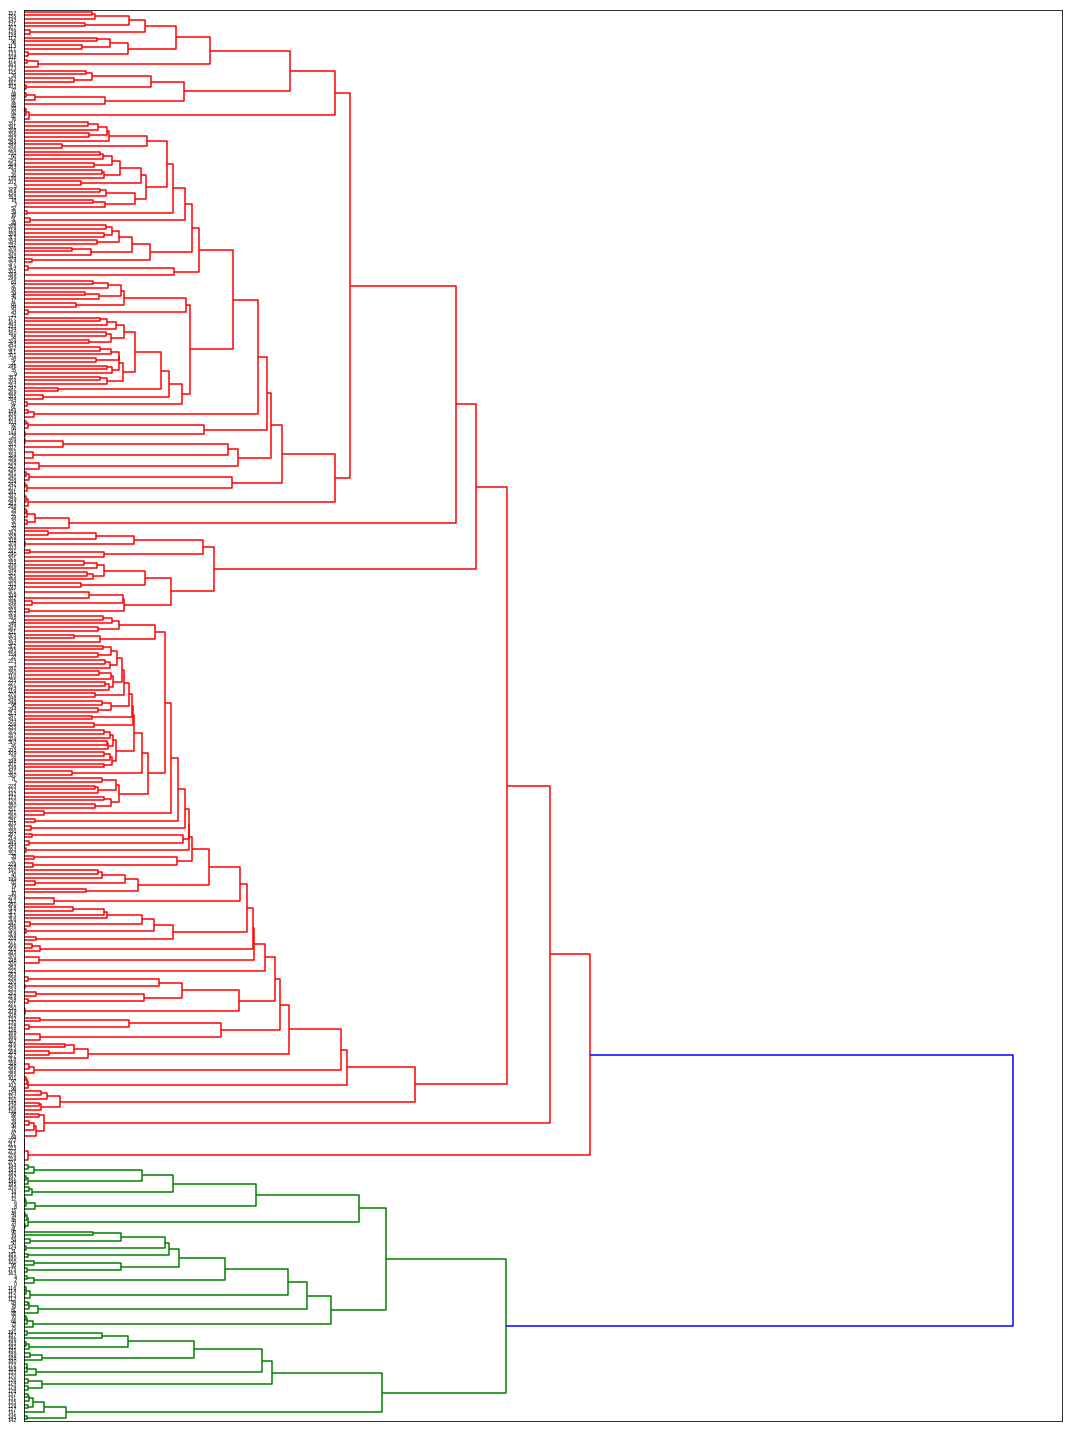

In [11]:
plot_dendogram('africa')

Africa is dominated by 3 classes even if we only see two colors.

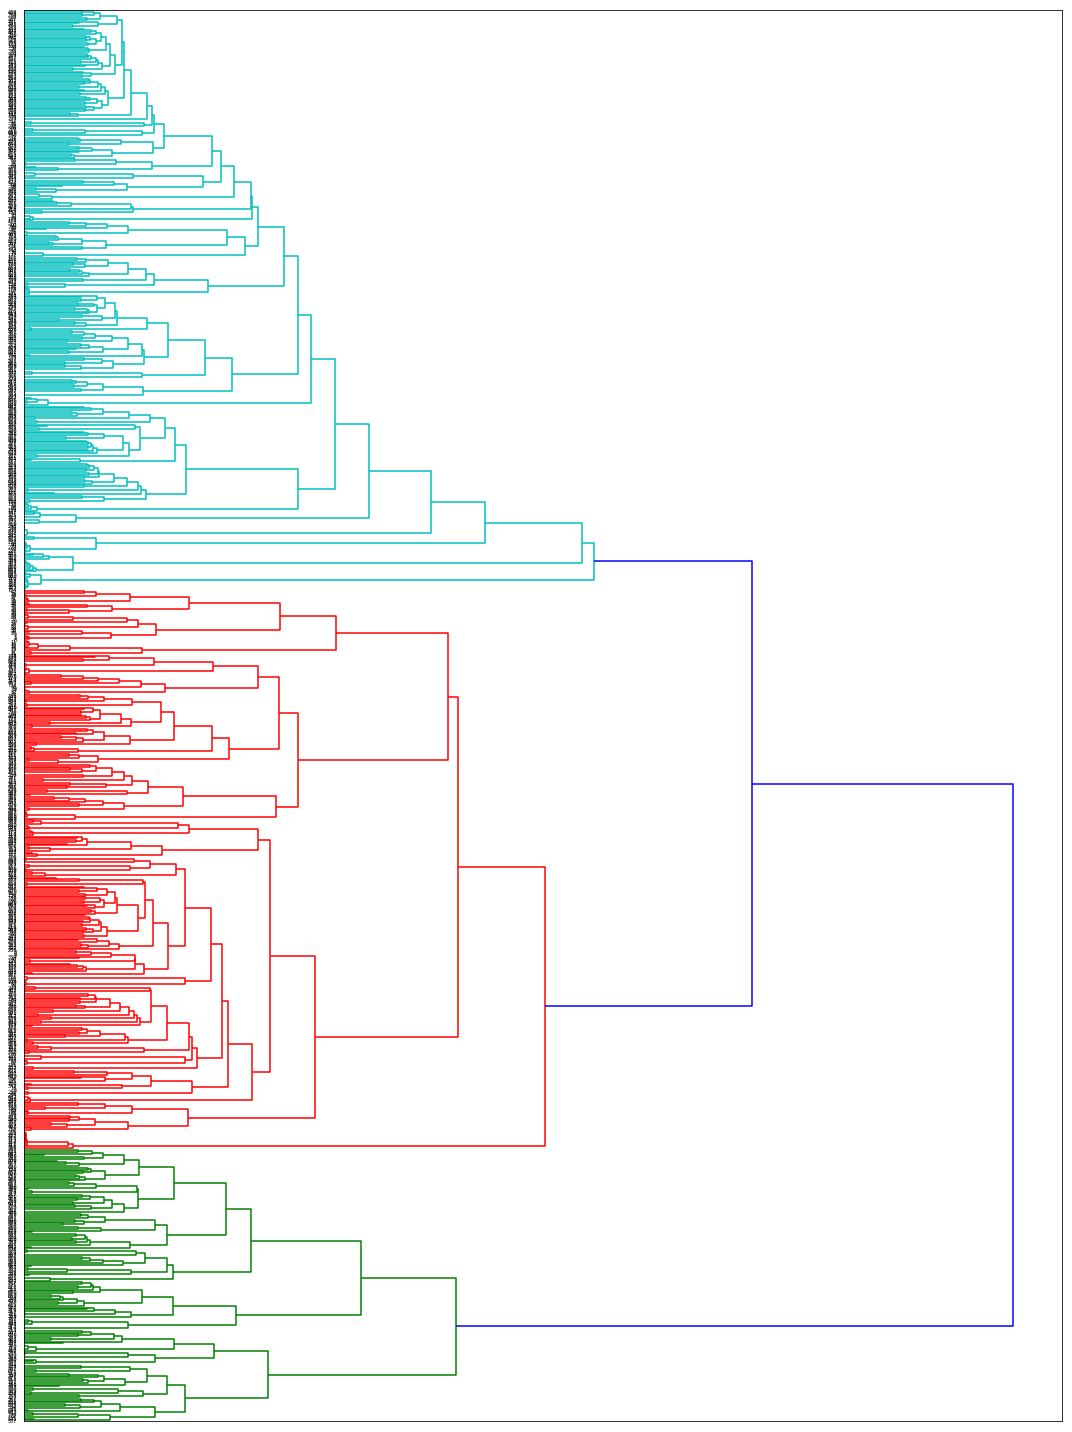

In [52]:
plot_dendogram('middle_east')

The middle east is divided into 3 classes.

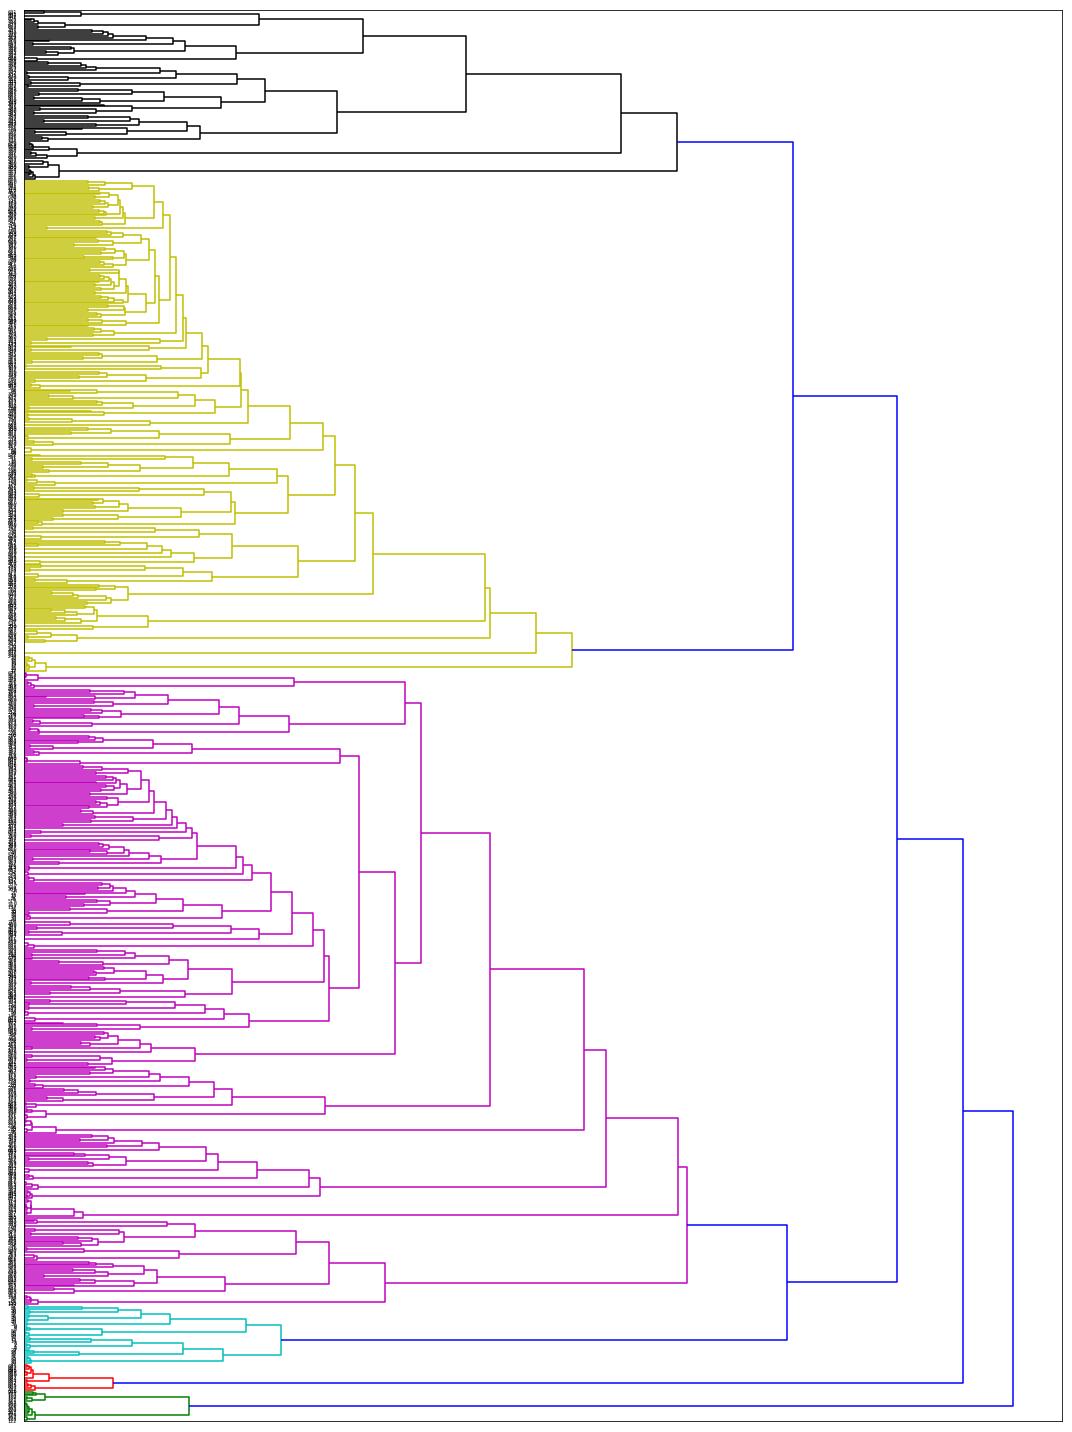

In [53]:
plot_dendogram('europe')

This diagram suggests Europe is not dominated by one or two topics in particular. We can explain that by the fact that Europe is interfering with many countries and organizations (EU, Libya, NATO, Iran, ...)

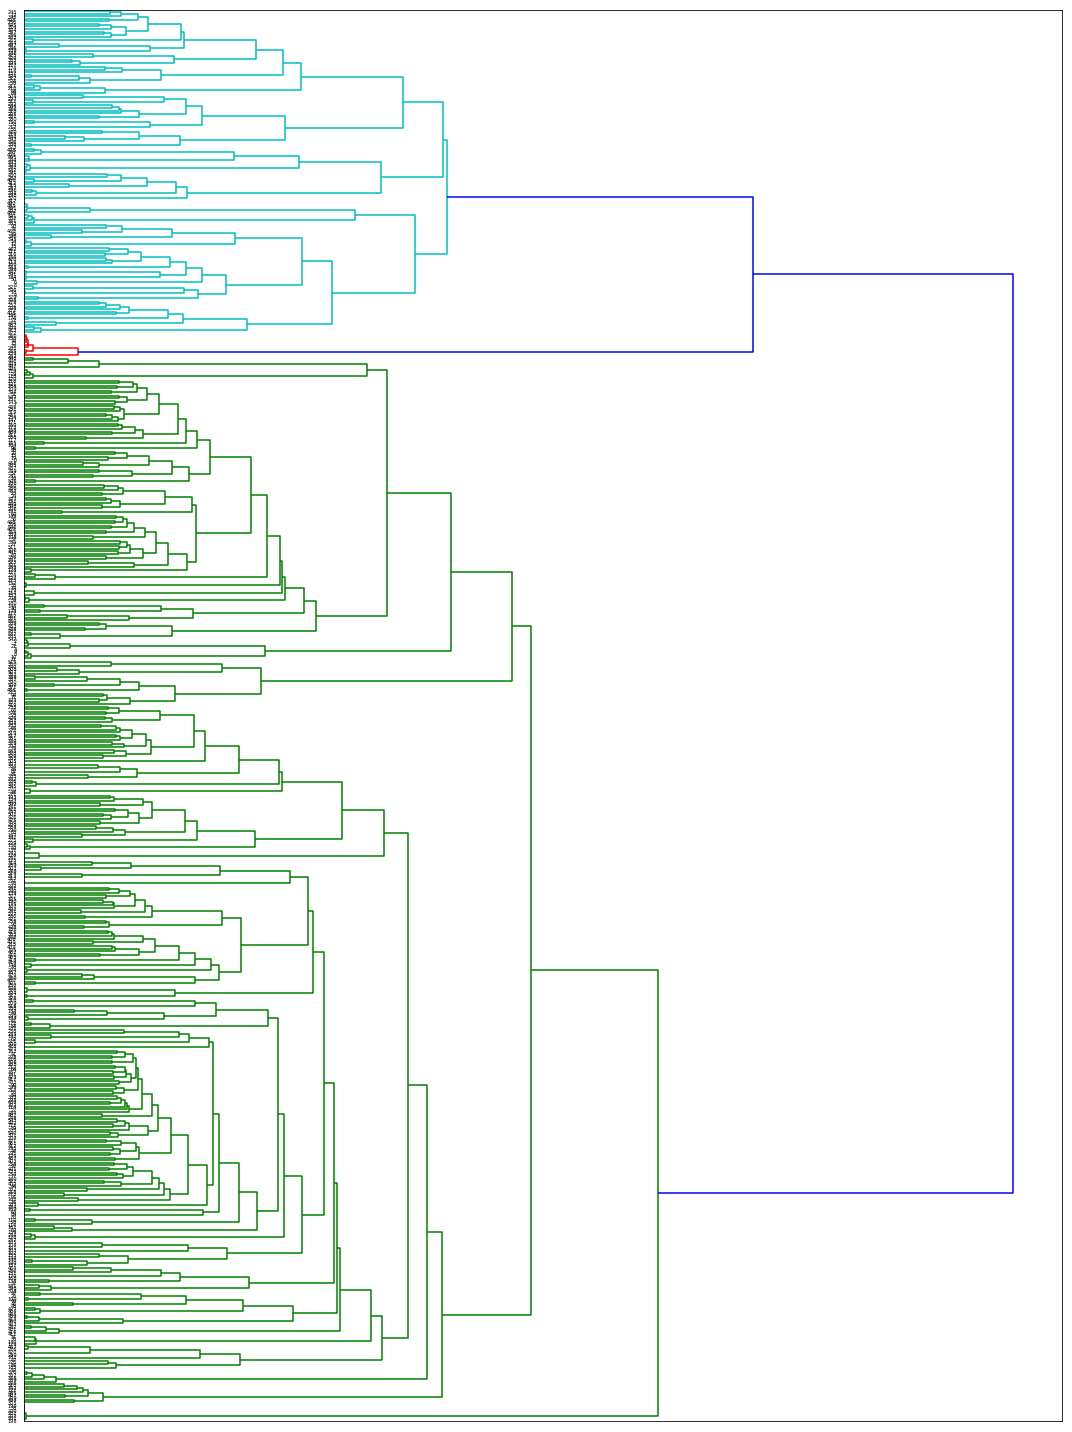

In [54]:
plot_dendogram('central_asia')

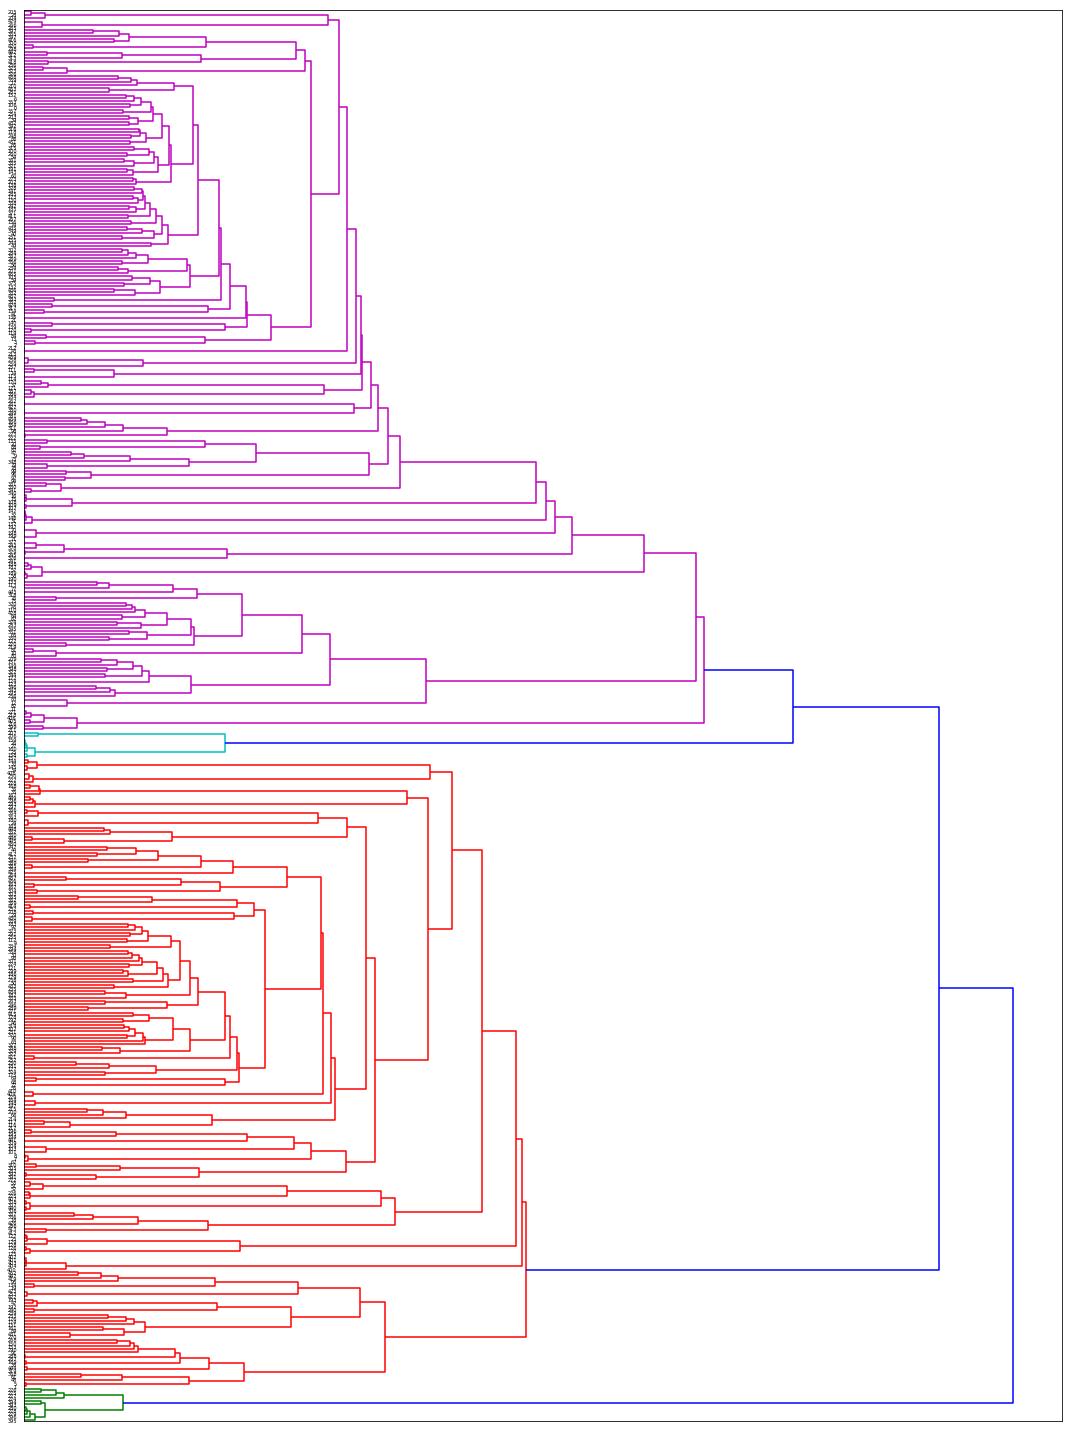

In [55]:
plot_dendogram('far_east')

An another way to vizualize these common words, then we use the function ``WordCloud`` from the package ``wordcloud`` and we use the continent as reference for the wordcloud. We follow this [tutorial](https://www.datacamp.com/community/tutorials/wordcloud-python)

In [70]:
#word cloud creation
def wordcloud_visualization(region):
    emails_filtered = emails[emails.content.map(lambda content: Extractor.earth_area(str(content), region))].content
    wordcloud = WordCloud(background_color="white").generate(str(emails_filtered))
    fig, ax = plt.subplots(figsize=(15, 20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

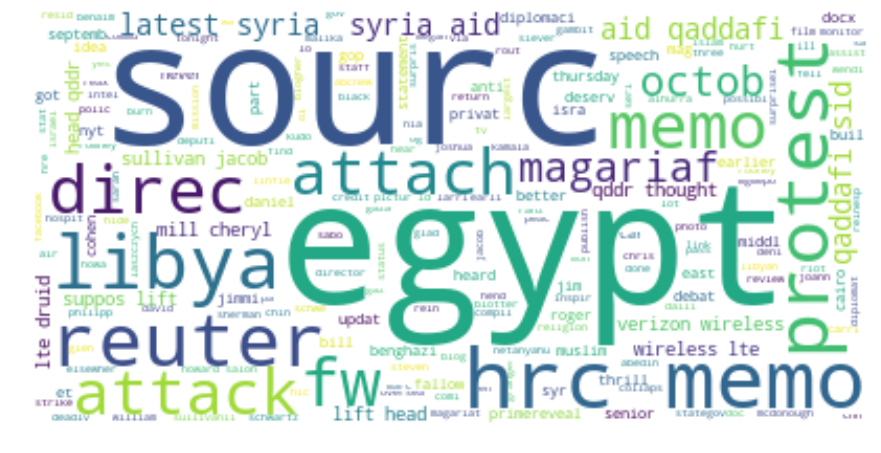

In [71]:
wordcloud_visualization('africa')

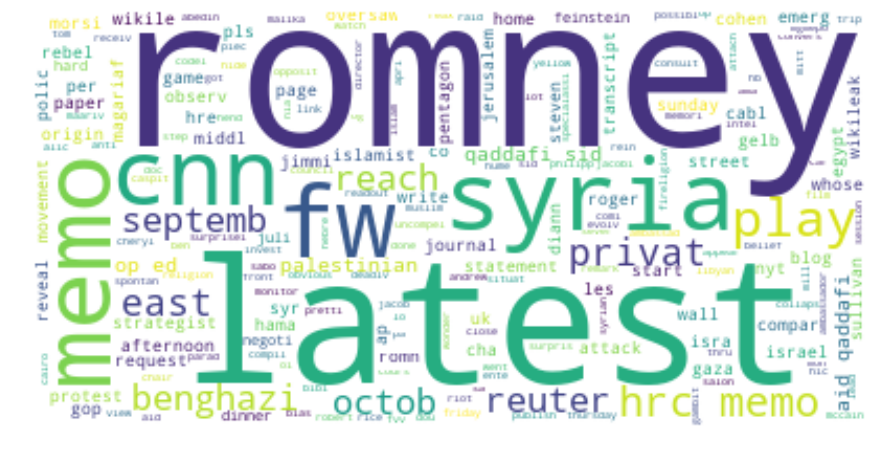

In [72]:
wordcloud_visualization('middle_east')

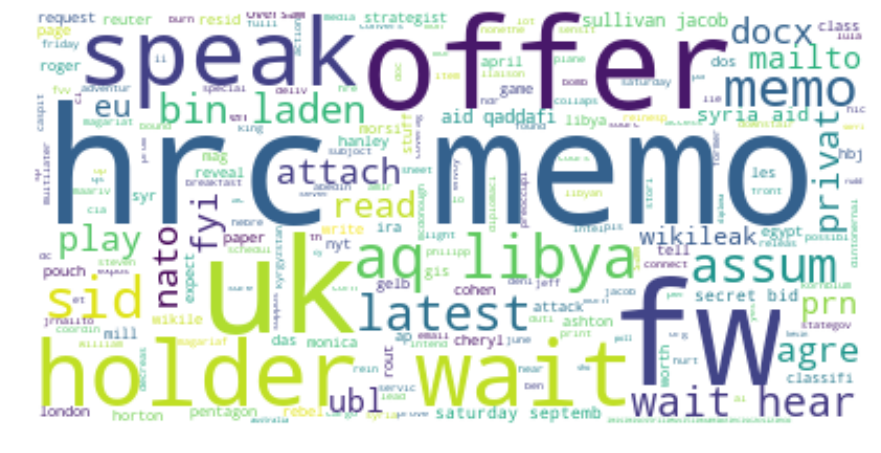

In [73]:
wordcloud_visualization('europe')

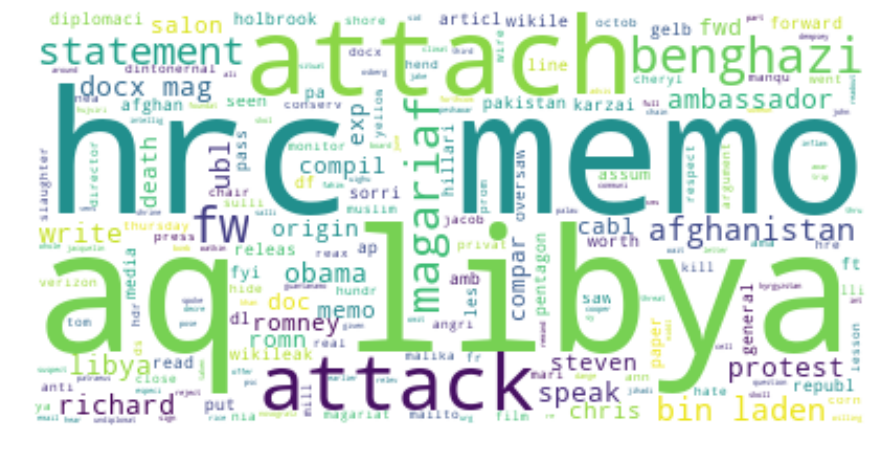

In [74]:
wordcloud_visualization('central_asia')

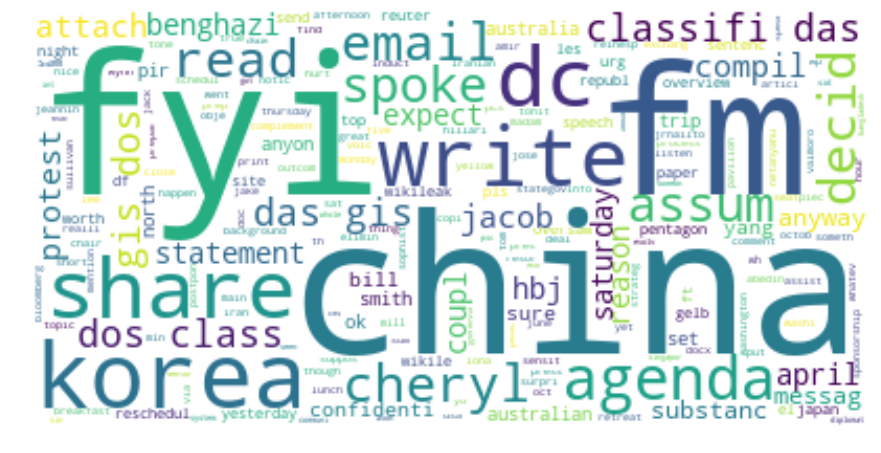

In [75]:
wordcloud_visualization('far_east')

With this wordcloud, it might be possible to visualize the most relevant used words in each region in order to see the different subjects. The subject that seems to appear in most of the region is Lybia and Benghazi. This is referred to the Benghazi War, where Clinton has investigated on.

## Network Analysis